<a href="https://colab.research.google.com/github/farenga/tf-neural-ode/blob/main/torch_neuralode_dense_dlrom_online.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
!pip install git+https://github.com/rtqichen/torchdiffeq

  Cloning https://github.com/rtqichen/torchdiffeq to /tmp/pip-req-build-ggtfqt3r
  Running command git clone -q https://github.com/rtqichen/torchdiffeq /tmp/pip-req-build-ggtfqt3r


In [127]:
import numpy as np
import scipy.io
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from IPython.display import display, clear_output
gpu = '0'
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

In [128]:
block_size = 400
train_size = 400
leave_out_for_time_test = block_size - train_size
batch_time = 100
batch_size = 20
niters = 2000
freq = 100
scaled = False
zeroflow = True
latent_dim = 2
n_params = 1

n_ensemble = 20
n_hidden = 128

data_noise = 0.001
n_data = batch_time
W1_var = 20. 
W_last_var = 1/n_hidden
W1_lambda = data_noise/W1_var
b1_var = W1_var
b1_lambda =  data_noise/b1_var
W_last_lambda = data_noise/W_last_var


In [129]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive/University/Courses/CS/cs-project/AEDLROM/data

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/University/Courses/CS/cs-project/AEDLROM/data


In [130]:
!ls

 S_latent_test_20_AE.mat
 S_latent_test_20_DLROM.mat
'S_latent_test_20_DLROM_p=2_scaled.mat'
 S_latent_train_20_AE.mat
 S_latent_train_20_DLROM.mat
'S_latent_train_20_DLROM_p=2_scaled.mat'


In [131]:
train_mat = scipy.io.loadmat('S_latent_train_20_DLROM_p=2_scaled.mat')
test_mat = scipy.io.loadmat('S_latent_test_20_DLROM.mat')
train_set = torch.tensor(train_mat['S'])
test_set = torch.tensor(test_mat['S'])

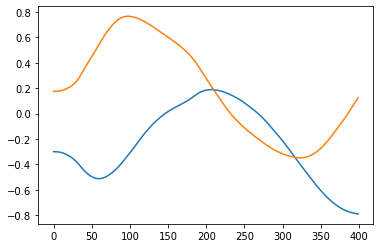

In [132]:
i=2
plt.plot(train_set[i*block_size:(i+1)*block_size,:])

In [133]:
scaling = train_set.max() if scaled else 1
train_set = torch.unsqueeze(train_set,1)/scaling

In [134]:
train_set.shape

torch.Size([8000, 1, 2])

In [135]:
params_ = torch.linspace(5e-3,5e-2,20).unsqueeze(1)
#params_ = torch.stack([params_,params_],-1)
params_.shape
params_blocked = torch.stack([params_[i,:] for i in range(20) for j in range(400)])
params_blocked = params_blocked.unsqueeze(1)

In [136]:
params_blocked.shape

torch.Size([8000, 1, 1])

In [137]:
train_set = torch.cat([train_set, params_blocked],-1)

In [138]:
train_set.shape

torch.Size([8000, 1, 3])

In [139]:
def get_batch(batch_time):
    # [0,...,batch_time]
    
    batch_t = torch.arange(batch_time).float()
        
    # first index of each block [0,400,800,1200,...,7600]
    start_idx = torch.arange(0,8000,block_size)
    
    # generate a random t0 for each block
    s_ = torch.from_numpy(np.random.choice(np.arange(block_size-batch_time-leave_out_for_time_test), batch_size, replace=False))
    # shift to match indexes 
    s = start_idx + s_

    # select u0 + params
    batch_u0 = train_set[s,:,:].float()
    batch_u0 = torch.cat([batch_u0, s_.unsqueeze(1).unsqueeze(1)],-1)
    # select parameters
    #batch_u0 = torch.stack([batch_u0,params_ ],1)
    
    # u(0),..., u(batch_time)
    batch_u = torch.stack([train_set[s+i,:,:] for i in range(batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), s.to(device)

In [179]:
def get_sample(batch_time):
    t_ = torch.arange(batch_time)
    # randomly select a block
    b_ = torch.from_numpy(np.random.choice(np.arange(0,8000,block_size),1, replace=False))
    s_ = torch.from_numpy(np.random.choice(np.arange(block_size-batch_time), 1, replace=False))
    # generate timesteps indexes
    s = t_ + s_*torch.ones_like(t_) + b_*torch.ones_like(t_)
    batch_t = s.float()/400
    # select u0 + params
    batch_u0 = train_set[s_,:,:].float()
    # select parameters
    #batch_u0 = torch.stack([batch_u0,params_ ],1)
    
    # u(0),..., u(batch_time)
    batch_u = torch.stack([train_set[s_+i,:,:] for i in range(batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), s.to(device)

In [156]:
s_ = torch.from_numpy(np.random.choice(np.arange(block_size-batch_time), 1))
s_

tensor([196])

In [159]:
def get_sample_test(batch_time):
    t_ = torch.arange(batch_time)
    # randomly select a block
    s_ = torch.from_numpy(np.random.choice(np.arange(8000-batch_time), 1))
    # generate timesteps indexes
    s = t_ + s_*torch.ones_like(t_)
    batch_t = s.float()/400
    # select u0 + params
    batch_u0 = train_set[s_,:,:].float()
    # select parameters
    #batch_u0 = torch.stack([batch_u0,params_ ],1)
    
    # u(0),..., u(batch_time)
    batch_u = torch.stack([train_set[s_+i,:,:] for i in range(batch_time)]).float()

    return batch_u0.to(device), batch_u.to(device), batch_t.to(device), s.to(device)

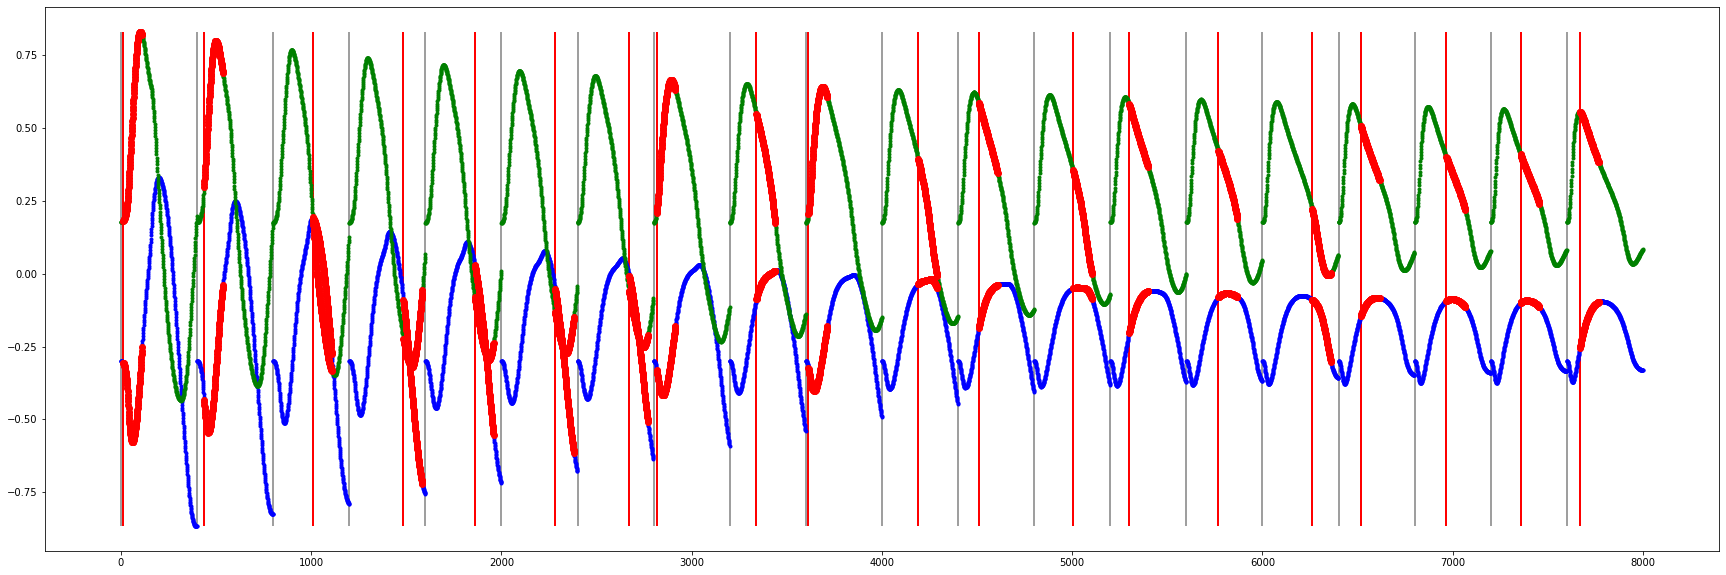

In [142]:
# VISUAL CHECK OF BATCHED DATA

with torch.no_grad():
    batch_u0, batch_u, batch_t, s = get_batch(100)

    plt.figure(figsize=(30,10))
    plt.vlines(np.arange(0,8000,400),train_set.min(),train_set.max(),color='gray')
    plt.vlines(s.cpu(),train_set.min(),train_set.max(),color='red',linewidth=2)
    plt.plot(train_set[:,:,0].cpu(),'.b')
    plt.plot(train_set[:,:,1].cpu(),'.g')
    for jj in range(batch_size):
        plt.plot(s[jj].cpu()+batch_t.cpu(),batch_u[:,jj,:,0].cpu(),'or')
        plt.plot(s[jj].cpu()+batch_t.cpu(),batch_u[:,jj,:,1].cpu(),'or')

In [143]:
batch_u0, batch_u, batch_t, s = get_sample(100)

batch_u0.shape,batch_u.shape, batch_t.shape

(torch.Size([1, 1, 3]), torch.Size([100, 1, 1, 3]), torch.Size([100]))

In [144]:
class DenseODEFunc(nn.Module):
    def __init__(self):
        super(DenseODEFunc, self).__init__()

        self.l1 = nn.Linear(4,64)
        self.l2 = nn.Linear(64,256)
        self.l3 = nn.Linear(256,512)
        self.l4 = nn.Linear(512,2)

        self.a = nn.Tanh()

    def forward(self, t, y):
        x = torch.cat((y,torch.tensor(batch_t)[0].unsqueeze(0).unsqueeze(0).unsqueeze(0)),-1)
        x = self.a(self.l1(x))
        x = self.a(self.l2(x))
        x = self.a(self.l3(x)) 
        x = self.l4(x)
        o = torch.cat([x,torch.zeros_like(y[:,:,-1]).unsqueeze(1)],-1)
        return o

func = DenseODEFunc().to(device)

In [145]:
batch_u0, batch_u, batch_t, _ = get_sample(10)
func.forward(batch_t,batch_u0)#.shape, batch_t.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


tensor([[[-0.1076, -0.0885,  0.0000]]], grad_fn=<CatBackward0>)

In [146]:
batch_u0, batch_u, batch_t, _ = get_sample(10)
pred_u = odeint(func, batch_u0, batch_t).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


In [211]:
lrate = 1e-5
optimizer = optim.Adam(func.parameters(), lr=lrate)
itr_time = []
loss_array = []
niters = 10000
for itr in range(1, niters + 1):

        start_itr = time.time()
        b = 5
        batch_u0, batch_u, batch_t, _ = get_sample(b)
        pred_u = odeint(func, batch_u0, batch_t).to(device)
        
        loss = torch.mean(torch.pow(pred_u - batch_u,2))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        itr_time.append(time.time()-start_itr)
        loss_array.append(loss.item())
        clear_output(wait=True)
        display('Iter ' + str(itr)+'/'+str(niters) + '  |  Loss: ' + str(round(loss.item(),6))  + '  |  batch time: ' + str(b))

        if itr % freq == 0:
            with torch.no_grad():
                print('Iter ' + str(itr)+'/'+str(niters) + '\t|  Loss: ' + str(round(loss.item(),6)) + '\t|  lr: ' + str(optimizer.param_groups[0]['lr']) + '\t|  itr time: ' +str(round(itr_time[-1],5))+' s')
                #       visualize(true_u, pred_u, func, ii, batch_u0, batch_t)
                #       ii += 1


'Iter 10000/10000  |  Loss: 1e-06  |  batch time: 5'

Iter 10000/10000	|  Loss: 1e-06	|  lr: 1e-05	|  itr time: 0.02644 s


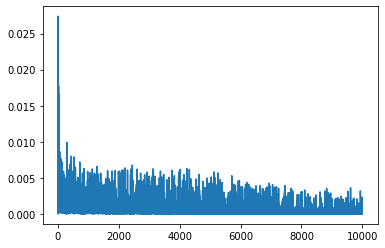

In [186]:
plt.plot(loss_array[:])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


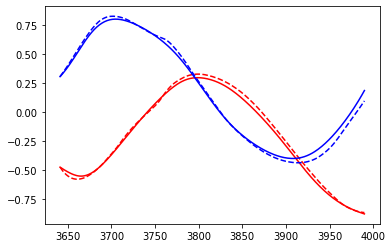

In [243]:
batch_u0, batch_u, batch_t, s = get_sample(350)
pred_u = odeint(func, batch_u0, batch_t).to(device)
plt.plot(s.detach(),pred_u[:,0,0,0].detach(),'-r')
plt.plot(s.detach(),batch_u[:,0,0,0].detach(),'--r')
plt.plot(s.detach(),pred_u[:,0,0,1].detach(),'-b')
plt.plot(s.detach(),batch_u[:,0,0,1].detach(),'--b')